In [ ]:
# BMI 계산 후 레이블 리턴하는 함수
# bmi = gk / m *m
# 18.5 미만 : thin
# 25 미만 : normal
# 25 이상 : fat

# 키 : cm( 120 ~ 200 사이의 정수)
# 몸무게 : kg (30 ~ 90 사이의 정수)

# 무작위로 데이터 20000개 생성
# {'thin': ? , 'normal': ?, 'fat':?}
# csv 파일 생성
# 키, 몸무게, label 의 형태로 담기

In [7]:
import numpy as np
import pandas as pd

def bmi_cacluate(height, weight):
    bmi = weight / (height / 100) ** 2
    if bmi < 18.5:
        return 'thin'
    elif bmi < 25:
        return 'normal'
    return 'fat'


In [21]:
# 무작위 데이터 20000개 생성, 카운팅까지

rand_data = []
data_counter = {'thin':0,'normal':0,'fat':0}
for i in range(20000):
    height = np.random.randint(120, 200)
    weight = np.random.randint(30, 90)
    label = bmi_cacluate(height, weight)
    data_counter[label] += 1
    rand_data.append([height, weight, label])

In [22]:
# csv 파일로 작성
df = pd.DataFrame(rand_data, columns=['height', 'weight', 'label'])
df.to_csv('bmi.csv', index=False)

# 그냥 file 써도 상관 없음
# f = open('bmi.csv' , 'w', encoding="UTF-8")
# f.write('height,weight,label\n)

In [23]:
data_counter

{'thin': 6303, 'normal': 5314, 'fat': 8383}

In [24]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf

tf.compat.v1.disable_eager_execution()

In [25]:
# csv 파일 읽어오기
csv = pd.read_csv('bmi.csv')
csv.head()

,height,weight,label
0,151,85,fat
1,173,82,fat
2,181,75,normal
3,199,81,normal
4,144,34,thin


In [26]:
# 키, 몸무게에 대한 기초 통계량  확인
csv.describe()

,height,weight
count,20000.000000,20000.000000
mean,159.520900,59.315000
std,23.185479,17.322505
min,120.000000,30.000000
25%,139.000000,44.000000
50%,159.000000,59.000000
75%,180.000000,74.000000
max,199.000000,89.000000


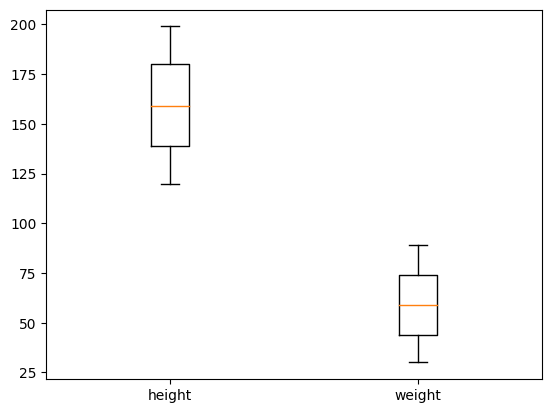

In [27]:
# boxplot으로 분포 확인
import matplotlib.pyplot as plt

plt.boxplot([csv['height'], csv['weight']], labels=['height', 'weight'])
plt.show()

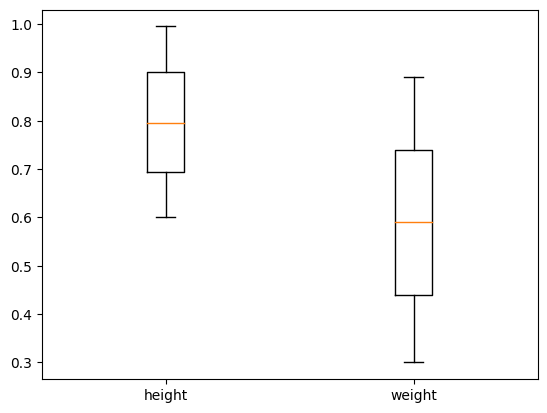

In [40]:
# 데이터 복제본 생성 & 정규화
csv1 = csv.copy()

# 키가 2미터를 넘지 않고, 몸무게가 100을 넘지 않는다는 전체하에 정규화
csv1['height'] = csv1['height'] / 200
csv1['weight'] = csv1['weight'] / 100

plt.boxplot([csv1['height'], csv1['weight']], labels=['height', 'weight'])
plt.show()

In [41]:
# 레이블을 배열로 변환
# One-hot encoding
# thin : [1,0,0] , normal : [ 0,1,0], fat:[0,0,1]
ohe = {'thin':[1,0,0], 'normal':[0,1,0], 'fat':[0,0,1]}

# One-hot Encoding으로 바꾼 내용의 컬럼 하나 더 생성
# Mapping으로 구현
csv1['label_ohe'] = csv1['label'].apply(lambda x : np.array(ohe[x]))

csv1.head()

,height,weight,label,label_ohe
0,0.755,0.85,fat,"[0, 0, 1]"
1,0.865,0.82,fat,"[0, 0, 1]"
2,0.905,0.75,normal,"[0, 1, 0]"
3,0.995,0.81,normal,"[0, 1, 0]"
4,0.720,0.34,thin,"[1, 0, 0]"


In [42]:
# 테스트를 위한 데이터 분리 (테스트용 데이터)

# 20000개 데이터 중 뒤쪽 5000개를 테스트데이터로 분리
test_csv = csv1[15000:]

# 학습을 위한 데이터  전처리
test_pat = test_csv[['weight', 'height']]
test_ans = list(test_csv['label_ohe'])

print(test_pat.head())
print(test_ans[:5])

       weight  height
15000    0.32   0.755
15001    0.31   0.980
15002    0.33   0.715
15003    0.39   0.810
15004    0.38   0.910
[array([1, 0, 0]), array([1, 0, 0]), array([1, 0, 0]), array([1, 0, 0]), array([1, 0, 0])]


In [43]:
# tensorflow의 모델 구성

tf.reset_default_graph() # 기존에 생성된 데이터 플로우 그래프 초기화

# 데이터 플로우 그래프 : 계산이나 데이터의 흐름을 표현하기 위한 그래프

In [44]:
# 신경망 구성

# 데이터 플로우 그래프 구축하기
# placeholder 생성

# 키와 몸무게 데이터를 넣기
x = tf.placeholder(tf.float32, [None,2])
# 정답 label
y_ = tf.placeholder(tf.float32, [None,3])

# 가중치와 편향
w = tf.Variable(tf.zeros([2,3]))
# 가중치 행렬 w : 모든 요소가 0인 2행 3열 행렬
# 입력 차원 2행 : 키, 몸무게 2개를 받겠다는 뜻
# 출력 차원 3열 : ('thin','normal','fat')의 3가지 클래스를 출력하겠다

b = tf.Variable(tf.zeros([3]))
# bias(편향) : 뉴런의 활성화를 조절하기위한 값
# bias를 0으로 초기화된 요소가 3개인 벡터로 생성
# 각 출력 노드(thin,normal,fat)에 대한 bias 값을 가짐

# 소프트맥스 회귀 모델 : one-hot encoding과 연결하기 위해 0~1 사이의 숫자로 바꾸는 역할
# classification 모델 중 하나임
y = tf.nn.softmax(tf.matmul(x,w) + b)

# lossfunction의 cross entropy : 모델의 예측값과 실제 정답이 얼마나 달라지는가를 판별하는 정보
# 분류 모델이 얼마나 잘 작동하는지 측정하기 위해 사용하는 지표
# y_*tf.log(y) 에는 크로스 엔트로피들의 2차원 텐서가 들어있음
# reduce_sum() 함수는 지정된 차원에 따라서 평균을 내는 함수
# 크로스 엔트로피(데이터의 불확실성)에서는 실제값과 예측값이 맞는 경우 0으로 수렴하고,
# 값이 틀릴 경우는 값이 커짐 => 실제값과 예측값의 차이의 정도를 보여줌
ce = -tf.reduce_sum(y_*tf.log(y))

# loss 값을 이용한 모델 최적화는 어떻게 할까?
# 최적화 : Gradient Descent(경사 하강법?)
# gradient의 절대값이 최소가 되는 방향으로 계속 반복 => 예측결과와 실제 결과의 차이 최소화
# 0.01 -> 학습 간격 (기울기의 하강 간격)
optimizer = tf.train.GradientDescentOptimizer(0.01)

# optimizer : 각각의 변수에 기대되는 값, 손실의 도함수의 정도에 따라 변수의 값을 변경
# 도함수 : Gradient 값을 구하기 위한 미분함수
# 텐서플로우에서는 도함수를 알아서 생성해줌

# 가중치, 편차를 보정
optimizer1 = optimizer.minimize(ce)

# 정답률 구하기
# 첫번째 파라미터 : 모델이 생각 할 때 가장 적합하다고 판단한 레이블
# 두번째 파라미터 : 실제 레이블
# equal을 사용해서 예측이 맞았는지 확인
predict = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

# 정답률에 대한 평균
score = tf.reduce_mean(tf.cast(predict, tf.float32))


In [49]:
# 실제 실행이 이루어지는 Session

with tf.Session() as sess:
    f_bmi = tf.summary.FileWriter('into_bmi', graph=sess.graph) # 그래프를 저장할 파일을 지정
    sess.run(tf.global_variables_initializer()) # 변수 초기화

    # 학습시키기 - 15000개의 데이터를 3500번 학습
    for step in range(3500):
        # 0~ 14999 까지 데이터를 100개씩 나눠서 학습시키기
        i = (step * 100) % 14000

        # 학습이 되는 행을 추출
        rows = csv1[1+i:1+i+100]

        # feature_data, lable_data를 분리
        xf = rows[['weight', 'height']]
        yf = list(rows['label_ohe'])

        feed_dict = {x:xf, y_:yf}

        #학습 진행
        sess.run(optimizer1, feed_dict=feed_dict)

        # 학습된 모델을 가지고 test를 진행할 때 콘솔에서 확인해보기
        # 반복횟수 500번마다
        if step % 500 == 0:
          ce1 = sess.run(ce, feed_dict={x:test_pat, y_:test_ans})
          ac = sess.run(score, feed_dict={x:test_pat, y_:test_ans})
          print('step=', step, 'cross entropy=', ce1, 'accuracy=', ac)

    #최종 정답률
    ac = sess.run(score, feed_dict={x:test_pat, y_:test_ans})
    print("정확도 : ",ac)

step= 0 cross entropy= 5352.9863 accuracy= 0.4256
step= 500 cross entropy= 2494.9824 accuracy= 0.8712
step= 1000 cross entropy= 2024.7024 accuracy= 0.8926
step= 1500 cross entropy= 1782.142 accuracy= 0.9314
step= 2000 cross entropy= 1620.261 accuracy= 0.937
step= 2500 cross entropy= 1504.0211 accuracy= 0.953
step= 3000 cross entropy= 1415.5597 accuracy= 0.9636
정확도 :  0.9612
